### Image Classification using LSTMs

In [1]:
import os
import torch
import torch.nn as nn
import torch.utils.data
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import glob
import torchvision
from torchvision.io import read_image

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to consistent dimensions
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Create a custom dataset class for the crater images
class CraterDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(img_dir, "*.jpg")) + \
                          glob.glob(os.path.join(img_dir, "*.png"))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
            
        # For autoencoder: input = target
        return image, image
    
# Create dataset and dataloader
crater_images_path = "Luna-1/crater_images"
dataset = CraterDataset(crater_images_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Visualize a sample of images
def show_batch(dataloader):
    batch_images, _ = next(iter(dataloader))
    grid = torchvision.utils.make_grid(batch_images[:16], nrow=4)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('Sample Crater Images')
    plt.show()

# Check if dataset loaded successfully
print(f"Dataset contains {len(dataset)} images")

# Process a batch to make it compatible with LSTM
# LSTM expects input of shape (batch_size, seq_length, input_size)
def prepare_batch_for_lstm(batch_images):
    batch_size = batch_images.size(0)
    # Reshape image to sequence: each row becomes a time step
    # From (batch_size, channels, height, width) to (batch_size, height, width*channels)
    if batch_images.shape[2] != 128 or batch_images.shape[3] != 128:
        batch_images = torch.nn.functional.interpolate(batch_images, size=(128, 128), mode='bilinear', align_corners=False)
    # sequences = batch_images.view(batch_size, 128, -1)
    return batch_images

Dataset contains 5067 images


In [2]:
class CraterAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(CraterAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

        self.encoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.relu = nn.GELU()
        self.fc = nn.Linear(hidden_size, input_size)
        print(f"models {self.encoder} {self.decoder} {self.fc}")

    
    def forward(self, x):
        _, (hidden_state, cell_state) = self.encoder(x)
        
        # Get sequence length and batch size
        batch_size, seq_length, _ = x.shape
        
        # Initialize decoder input (start token)
        decoder_input = torch.zeros(batch_size, 1, self.input_size).to(self.device)
        
        # Initialize output tensor to store decoder outputs
        outputs = torch.zeros(batch_size, seq_length, self.input_size).to(self.device)
        
        
        # Decode sequence step by step
        for t in range(seq_length):
            # Pass through decoder LSTM
            # print(f"decoder_input shape: {decoder_input.shape}")
            out, (hidden_state, cell_state) = self.decoder(decoder_input, (hidden_state, cell_state))
            
            # Apply fully connected layer to get output
            out = self.fc(out)
            
            # Store output
            outputs[:, t:t+1, :] = out
            
            # Next input is current output (teacher forcing could be used here instead)
            decoder_input = out
        
        return outputs
    
class CAEAutoencoder(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=1):
        super(CAEAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

        # input_size = 128  # Width * channels (128*1 for grayscale)
        # hidden_size = 64  # Size of compressed representation
        # num_layers = 2    # Number of LSTM layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),   # -> (32, 64, 64)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # -> (64, 32, 32)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # -> (128, 16, 16)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# -> (256, 8, 8)
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),# -> (512, 4, 4)
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), # -> (256, 8, 8)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # -> (128, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # -> (64, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # -> (32, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),    # -> (1, 128, 128)
            nn.Tanh()  # use Tanh if your images are normalized to [-1, 1]
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x

        

In [3]:
class CraterAutoencoderTrainer:
    def __init__(self, input_size, hidden_size, num_layers, learning_rate=0.001):
        """
        Initialize the trainer for CraterAutoencoder.
        
        Args:
            input_size: Size of input features (width*channels for each row)
            hidden_size: Size of hidden representation
            num_layers: Number of LSTM layers
            learning_rate: Learning rate for optimizer
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        # self.model = CraterAutoencoder(input_size, hidden_size, num_layers).to(self.device)
        self.model = CAEAutoencoder(input_size, hidden_size, num_layers).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.train_losses = []
        self.val_losses = []
        
    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        
        for images, _ in train_loader:
            # Convert images to sequences
            sequences = prepare_batch_for_lstm(images).to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(sequences)
            
            # Calculate loss
            loss = self.criterion(outputs, sequences)
            # print(f"loss: {loss.item()}")

            # Backward pass and optimize
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(train_loader)
    
    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for images, _ in val_loader:
                sequences = prepare_batch_for_lstm(images).to(self.device)
                outputs = self.model(sequences)
                loss = self.criterion(outputs, sequences)
                total_loss += loss.item()
                
        return total_loss / len(val_loader)
    
    def train(self, train_loader, val_loader, num_epochs, checkpoint_dir='checkpoints'):
        """Train the model for multiple epochs"""
        # Create checkpoint directory if it doesn't exist
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        print(f"Training on {self.device}")
        best_val_loss = float('inf')
        
        for epoch in range(num_epochs):
            # Train and validate
            train_loss = self.train_epoch(train_loader)
            val_loss = self.validate(val_loader)
            
            # Store losses
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            # Print progress
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
            
            # Save checkpoint if we have the best model so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_checkpoint(os.path.join(checkpoint_dir, f"best_model.pt"))
            
            # Save regular checkpoint
            if (epoch + 1) % 5 == 0:
                self.save_checkpoint(os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt"))
                
        # Plot training history
        self.plot_training_history()
                
    def save_checkpoint(self, path):
        """Save model checkpoint"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, path)
        
    def load_checkpoint(self, path):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        
    def plot_training_history(self):
        """Plot training and validation loss"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def visualize_reconstructions(self, test_loader, num_samples=5):
        """Visualize original images and their reconstructions"""
        self.model.eval()
        
        with torch.no_grad():
            # Get a batch of images
            images, _ = next(iter(test_loader))
            images = images[:num_samples]
            
            # Convert to sequences and get reconstructions
            sequences = prepare_batch_for_lstm(images).to(self.device)
            reconstructions = self.model(sequences)
            
            # Convert back to images
            reconstructed_images = reconstructions.view(images.shape[0], 1, 128, 128).cpu()
            
            # Plot original and reconstructed images side by side
            fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples*3))
            
            for i in range(num_samples):
                # Original image
                axes[i, 0].imshow(images[i].squeeze().cpu(), cmap='gray')
                axes[i, 0].set_title(f"Original {i+1}")
                axes[i, 0].axis('off')
                
                # Reconstructed image
                axes[i, 1].imshow(reconstructed_images[i].squeeze().cpu(), cmap='gray')
                axes[i, 1].set_title(f"Reconstructed {i+1}")
                axes[i, 1].axis('off')
                
                # Compute similarity (e.g., MSE)
                orig = images[i].cpu().numpy().flatten()
                recon = reconstructed_images[i].cpu().numpy().flatten()
                mse = ((orig - recon) ** 2).mean()
                print(f"Sample {i+1} similarity (MSE): {mse:.6f}")
                
            plt.tight_layout()
            plt.show()


Training on cuda
Epoch 1/200, Train Loss: 0.051516, Val Loss: 0.013168
Epoch 2/200, Train Loss: 0.011860, Val Loss: 0.010091
Epoch 3/200, Train Loss: 0.008347, Val Loss: 0.007379
Epoch 4/200, Train Loss: 0.007074, Val Loss: 0.006361
Epoch 5/200, Train Loss: 0.006318, Val Loss: 0.006057
Epoch 6/200, Train Loss: 0.005660, Val Loss: 0.006393
Epoch 7/200, Train Loss: 0.005181, Val Loss: 0.004696
Epoch 8/200, Train Loss: 0.004800, Val Loss: 0.004400
Epoch 9/200, Train Loss: 0.004395, Val Loss: 0.004102
Epoch 10/200, Train Loss: 0.004245, Val Loss: 0.003793
Epoch 11/200, Train Loss: 0.003858, Val Loss: 0.004076
Epoch 12/200, Train Loss: 0.003658, Val Loss: 0.003291
Epoch 13/200, Train Loss: 0.003465, Val Loss: 0.003511
Epoch 14/200, Train Loss: 0.003323, Val Loss: 0.003055
Epoch 15/200, Train Loss: 0.003124, Val Loss: 0.002965
Epoch 16/200, Train Loss: 0.003104, Val Loss: 0.002931
Epoch 17/200, Train Loss: 0.003008, Val Loss: 0.002873
Epoch 18/200, Train Loss: 0.003057, Val Loss: 0.002798
Ep

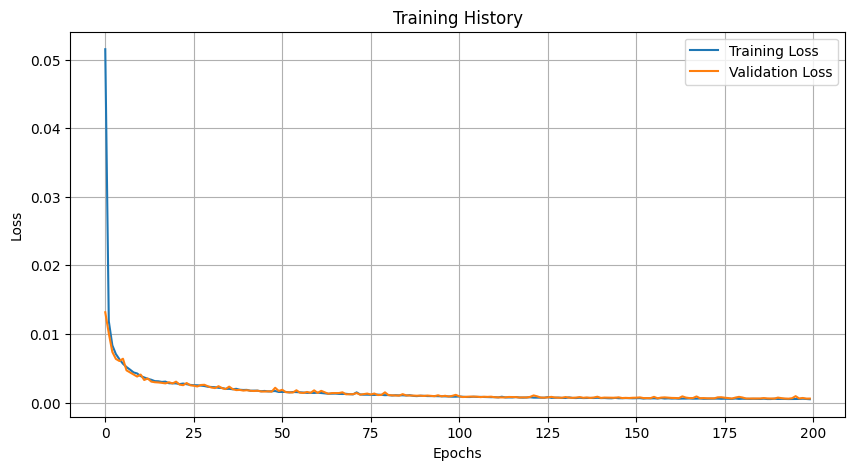

Sample 1 similarity (MSE): 0.000652
Sample 2 similarity (MSE): 0.000107
Sample 3 similarity (MSE): 0.000208
Sample 4 similarity (MSE): 0.000220
Sample 5 similarity (MSE): 0.000700


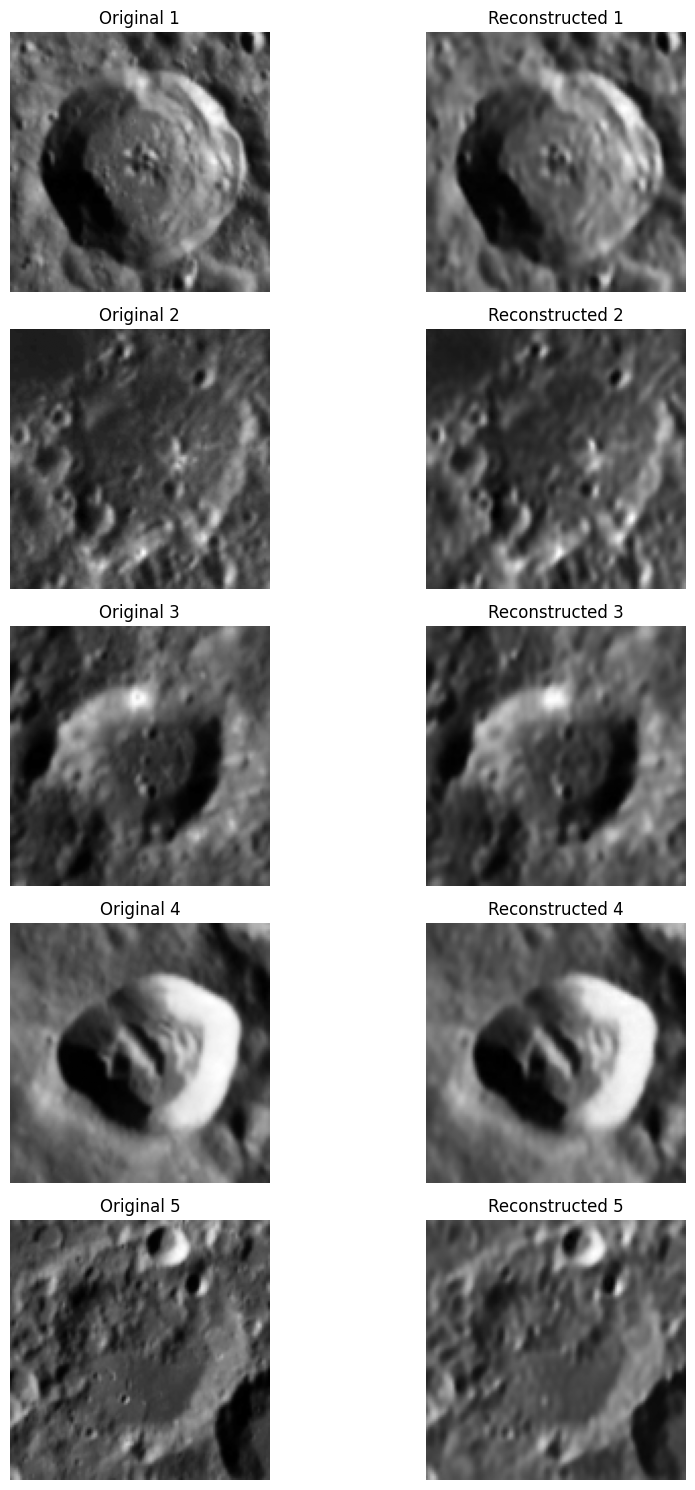

In [4]:
# Split data into train and validation sets
from torch.utils.data import random_split

# Assuming your dataset is already created
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize trainer
# For 128x128 grayscale images, input_size would be 128 (width*channels for each row)
input_size = 128  # Width * channels (128*1 for grayscale)
hidden_size = 64  # Size of compressed representation
num_layers = 2 

trainer = CraterAutoencoderTrainer(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    learning_rate=0.001
)

# Train the model
trainer.train(train_loader, val_loader, num_epochs=200)
trainer.load_checkpoint('checkpoints/best_model.pt')

# Visualize some reconstructions
trainer.visualize_reconstructions(val_loader, num_samples=5)

In [ ]:
#load a image and find craters in it 
class Luna1Detector():
    def __init__(self, model):
        self.model = model
        self.device = model.device

    # full_image_directory = "Luna-1/lro_navigation/nav_images"

    transform_full_image = transforms.Compose([
        transforms.Resize((512, 512)),  # Resize images to consistent dimensions
        transforms.ToTensor(),          # Convert to tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
    ])
    fig, ax = plt.subplots(figsize=(8, 8))

    def load_and_prepare_image(self, image_path):
        """Load and prepare a single image for the model."""
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = self.transform_full_image(image)  # Apply transformations
        
        return image.unsqueeze(0)  # Add batch dimension

    def find_craters_in_image(self, image_path, cutout_size = 128, stride=64):
        image = self.load_and_prepare_image(image_path)
        #loop over the image in 128x128 patches
        patches = []
        img_tensor = image.squeeze(0)  # Remove batch dimension for processing
        # print(f"Image shape: {img_tensor.shape}")
        for i in range(0, img_tensor.shape[1] - cutout_size + 1, stride):
            for j in range(0, img_tensor.shape[2] - cutout_size + 1, stride):
                # print(f"Processing patch at ({i}, {j})")
                patch = img_tensor[:, i:i+cutout_size, j:j+cutout_size].unsqueeze(0)  # Add batch dimension
                patches.append(patch)
        patches = torch.cat(patches, dim=0).to(model.device)  # Combine all patches into a single tensor
        patches = prepare_batch_for_lstm(patches).to(model.device)
        sequences = patches
        # sequences = prepare_batch_for_lstm(patches).to(model.device)
        # print(f"sequences.shape: {sequences.shape}")
        with torch.no_grad():
            reconstructions = model(sequences)
        # print(f"reconstructions.shape: {reconstructions.shape}")
        #compare reconstructed patches with original patches
        mses = []
        for i in range(reconstructions.shape[0]):
            reconstructed_patch = reconstructions[i].view(1, 1, 128, 128)
            reconstructed_patch = reconstructed_patch.cpu()  # Move to CPU for visualization
            patches[i] = patches[i].cpu()  # Move original patch to CPU for visualization

            orig = patches[i].squeeze().cpu().numpy().flatten()
            recon = reconstructed_patch.squeeze().cpu().numpy().flatten()
            mses.append(((orig - recon) ** 2).mean())
            # print(f"Patch {i+1} similarity (MSE): {mses[-1]:.6f}")

        # Draw a square over best matching patches
        

        # Find top 10% mses
        
        found = []        
        for i in range(len(mses)):
            # if mses[i] < 0.0003:  # Threshold for similarity
            row = ((i * stride) // img_tensor.shape[2])*stride
            col = (i * stride) % img_tensor.shape[2]
            # rect = plt.Rectangle((col, row), cutout_size, cutout_size, edgecolor='red', facecolor='none')
            # self.ax.add_patch(rect)
            found.append((row, col, cutout_size, cutout_size, mses[i]))
        return found

    def find_craters(self,image_path):
        stride = 8
        sizes = [32, 64, 128]
        reconstructions = []
        
        for size in sizes:
            print(f"Finding craters with size {size} and stride {stride}")
            reconstructions.append(self.find_craters_in_image(image_path, size, stride))
            print(f"Found {len(reconstructions)} patches of size {size} in the image.")
        top_k = int(len(reconstructions) * 0.05)
        top_indices = sorted(range(len(reconstructions)), key=lambda i: reconstructions[i][-1])[:top_k]
        
        for i in top_indices:
        # Draw rectangles around the detected craters
            row, col, width, height, mse = reconstructions[i]
            rect = plt.Rectangle((col, row), width, height, edgecolor='red', facecolor='none')
            self.ax.add_patch(rect)
            # print(f"Detected crater at ({row}, {col}) with size ({width}, {height}) and MSE: {mse:.6f}")



        img = Image.open(image_path).convert('L')
        self.ax.imshow(img, cmap='gray')
        plt.title("Detected Craters")
        plt.axis('off')
        plt.show()


# Example usage

input_size = 128  # Width * channels (128*1 for grayscale)
hidden_size = 64  # Size of compressed representation
num_layers = 2 

trainer = CraterAutoencoderTrainer(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    learning_rate=0.001
)
trainer.load_checkpoint('checkpoints/best_model.pt')
image_path = "Luna-1/lro_navigation/nav_images/16.png"  # Replace with your image path
model = trainer.model  # Use the trained model
detector = Luna1Detector(model)
detector.find_craters(image_path)


Finding craters with size 32 and stride 8
